In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import os
import sys
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import tqdm

from density import KNeighborsDensity, SplitKNeighborsDensity, SplitMedianNeighborsDensity

In [26]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Define a random mixture of gaussians

In [3]:
def draw_mog(d=5, n_components=10, n_samples=1000, seed=0):
    np.random.seed(seed)
    centers = multivariate_normal(np.zeros(d), 10 * np.eye(d)).rvs(n_components)
    samples = []
    for center in centers:
        samples.append(multivariate_normal(center).rvs(n_samples // n_components).reshape((-1, d)))
    return np.vstack(samples), centers


In [5]:
def mog_density(centers, pos):
    pdf = 0.
    for center in centers:
        pdf += multivariate_normal(center).pdf(pos)
    return pdf / len(centers)

### Visualization for 1D case

[ 5.57842333  1.2654082   3.09504126  7.0863265   5.90573691 -3.09042401
  3.00444338 -0.47863352 -0.32640667  1.29842647]


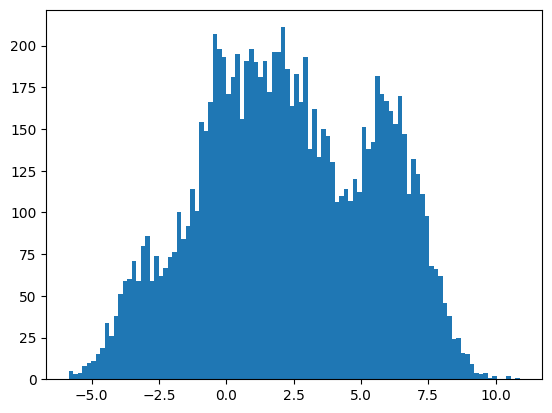

In [4]:
samples, centers = draw_mog(d=1, n_samples=10000)
plt.hist(samples, bins=100)
print(centers)

### Visualization for 2D case

(-10.0, 9.990000000000002, -10.0, 9.990000000000002)

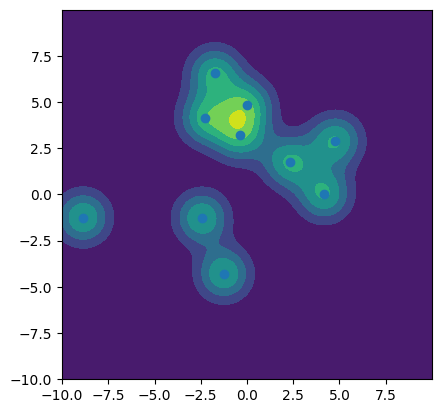

In [7]:
d = 2

n_components = 10
centers = multivariate_normal(np.zeros(d), 10 * np.eye(d)).rvs(n_components)

x, y = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.dstack((x, y))

pdf = 0.
for center in centers:
    rv = multivariate_normal(center)
    pdf += rv.pdf(pos)

plt.contourf(x, y, pdf / len(centers))
plt.scatter(*zip(*centers))
plt.axis('square')

## Experiment

In [14]:
dims = [1, 2, 3, 4, 5]
ns = [10 ** k for k in range(2, 7)]
ks = [1, 2, 3, 4, 5]
n_components = 10
num_seeds = 10
ntest = 10000

In [36]:
errs_l2 = dict()
errs_linf = dict()
for d in dims:
    # errs_l2[d] = defaultdict(lambda: np.zeros((len(ns), num_seeds)).astype(float))
    # errs_linf[d] = defaultdict(lambda: np.zeros((len(ns), num_seeds)).astype(float))
    for i, N in enumerate(ns):
        # print(f'dim={d},N={N}')
        n_splits = np.ceil(N ** (4 / (d + 4)) / 2).astype(int)
        print(d, N, n_splits)                        

1 100 20
1 1000 126
1 10000 793
1 100000 5001
1 1000000 31548
2 100 11
2 1000 50
2 10000 233
2 100000 1078
2 1000000 5000
3 100 7
3 1000 26
3 10000 97
3 100000 360
3 1000000 1342
4 100 5
4 1000 16
4 10000 50
4 100000 159
4 1000000 500
5 100 4
5 1000 11
5 10000 30
5 100000 84
5 1000000 233


In [37]:
errs_l2 = dict()
errs_linf = dict()
for d in dims:
    errs_l2[d] = defaultdict(lambda: np.zeros((len(ns), num_seeds)).astype(float))
    errs_linf[d] = defaultdict(lambda: np.zeros((len(ns), num_seeds)).astype(float))
    for i, N in enumerate(ns):
        print(f'dim={d},N={N}')
        n_splits = np.ceil(N ** (4 / (d + 4))).astype(int) // 10
        for j, seed in tqdm(enumerate(range(num_seeds))):
            X, centers = draw_mog(d=d, n_components=n_components, n_samples=N, seed=seed)
            X_test, _ = draw_mog(d=d, n_components=n_components, n_samples=ntest, seed=seed)
            true_dens = mog_density(centers, X_test)
            X_plot = X_test
            
            # (baseline) standard k-NN density estimator
            knn_estimator = KNeighborsDensity(n_neighbors=n_splits).fit(X)
            log_dens_knn = knn_estimator.score_samples(X_test)
            errs_l2[d]['knn'][i, j] = ((np.exp(log_dens_knn) - true_dens) ** 2).sum()
            errs_linf[d]['knn'][i, j] = (np.abs(np.exp(log_dens_knn) - true_dens)).max()
        
            for k in ks:
                # canonical
                split_knn_estimators = SplitKNeighborsDensity(n_neighbors=k, n_splits=np.max([n_splits // k, 1])).fit(X)
                log_dens_split_knn = split_knn_estimators.score_samples(X_test, alphas=[-1, 1])  # AM, GM, HM
            
                # GM
                errs_l2[d][f'split_{k}nn_gm'][i, j] = ((np.exp(log_dens_split_knn['type1_log']) - true_dens) ** 2).sum()
                errs_linf[d][f'split_{k}nn_gm'][i, j] = (np.abs(np.exp(log_dens_split_knn['type1_log']) - true_dens)).max()
            
                # AM
                errs_l2[d][f'split_{k}nn_am'][i, j] = ((np.exp(log_dens_split_knn['type1_poly_1']) - true_dens) ** 2).sum()
                errs_linf[d][f'split_{k}nn_am'][i, j] = (np.abs(np.exp(log_dens_split_knn['type1_poly_1']) - true_dens)).max()
            
                # HM
                errs_l2[d][f'split_{k}nn_hm'][i, j] = ((np.exp(log_dens_split_knn['type1_poly_-1']) - true_dens) ** 2).sum()
                errs_linf[d][f'split_{k}nn_hm'][i, j] = (np.abs(np.exp(log_dens_split_knn['type1_poly_-1']) - true_dens)).max()
        
                # errs_l2[d][f'split_{k}nn_-2'][i, j] = ((np.exp(log_dens_split_knn['type1_poly_-2']) - true_dens) ** 2).sum()
                # errs_linf[d][f'split_{k}nn_-2'][i, j] = (np.abs(np.exp(log_dens_split_knn['type1_poly_-2']) - true_dens)).max()
        
                # errs_l2[d][f'split_{k}nn_2'][i, j] = ((np.exp(log_dens_split_knn['type1_poly_2']) - true_dens) ** 2).sum()
                # errs_linf[d][f'split_{k}nn_2'][i, j] = (np.abs(np.exp(log_dens_split_knn['type1_poly_2']) - true_dens)).max()
                    
                # median
                split_knn_median_estimator = SplitMedianNeighborsDensity(n_neighbors=k, n_splits=np.max([n_splits // k, 1])).fit(X)
                log_dens_split_knn_median = split_knn_median_estimator.score_samples(X_test)
                errs_l2[d][f'split_{k}nn_median'][i, j] = ((np.exp(log_dens_split_knn_median) - true_dens) ** 2).sum()
                errs_linf[d][f'split_{k}nn_median'][i, j] = (np.abs(np.exp(log_dens_split_knn_median) - true_dens)).max()
                

dim=1,N=100


0it [00:00, ?it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
2it [00:00, 15.04it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
9it [00:00, 18.63it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_e

dim=1,N=1000


10it [00:02,  3.39it/s]


dim=1,N=10000


10it [00:19,  1.94s/it]


dim=1,N=100000


10it [02:30, 15.06s/it]


dim=1,N=1000000


10it [17:33, 105.40s/it]


dim=2,N=100


0it [00:00, ?it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
2it [00:00, 15.00it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(


dim=2,N=1000


10it [00:02,  4.68it/s]


dim=2,N=10000


10it [00:12,  1.26s/it]


dim=2,N=100000


10it [01:07,  6.70s/it]


dim=2,N=1000000


10it [05:18, 31.85s/it]


dim=3,N=100


0it [00:00, ?it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:252: RuntimeWarning: divide by zero encountered in log
  return np.log(k - 1) - log_U
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:252: RuntimeWarning: divide by zero encountered in log
  return np.log(k - 1) - log_U
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
2it [00:00, 14.14it/s]/Users/jongha/Dropbox/src/_knn/s

dim=3,N=1000


10it [00:01,  5.22it/s]


dim=3,N=10000


10it [00:07,  1.28it/s]


dim=3,N=100000


10it [00:39,  3.91s/it]


dim=3,N=1000000


10it [03:09, 18.93s/it]


dim=4,N=100


0it [00:00, ?it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:252: RuntimeWarning: divide by zero encountered in log
  return np.log(k - 1) - log_U
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:252: RuntimeWarning: divide by zero encountered in log
  return np.log(k - 1) - log_U
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
2it [00:00, 13.64it/s]/Users/jongha/Dropbox/src/_knn/s

dim=4,N=1000


8it [00:01,  5.98it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
10it [00:01,  5.76it/s]


dim=4,N=10000


10it [00:06,  1.59it/s]


dim=4,N=100000


10it [00:27,  2.77s/it]


dim=4,N=1000000


10it [02:17, 13.73s/it]


dim=5,N=100


0it [00:00, ?it/s]/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:214: RuntimeWarning: divide by zero encountered in log
  + self.d * np.log(kth_neigh_dist)  # (n_samples, n_k)
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:252: RuntimeWarning: invalid value encountered in log
  return np.log(k - 1) - log_U
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:342: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:347: RuntimeWarning: divide by zero encountered in log
  log_densities[f'type1_exp_{beta}'] = np.log(
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:214: RuntimeWarning: divide by zero encountered in log
  + self.d * np.log(kth_neigh_dist)  # (n_samples, n_k)
/Users/jongha/Dropbox/src/_knn/split-knn-rules/density.py:252: RuntimeWarning: invalid value encountered in log
  return np.log(k - 1) - log_U
/Users/jongha/Dropbox/src/_knn/split-k

dim=5,N=1000


10it [00:01,  5.07it/s]


dim=5,N=10000


10it [00:06,  1.62it/s]


dim=5,N=100000


10it [00:28,  2.89s/it]


dim=5,N=1000000


10it [02:13, 13.38s/it]


### Plotting the results

In [52]:
colors = {
    'knn': 'brown',
    'split_nn_am': 'blue',
    'split_nn_gm': 'red',
    'split_nn_hm': 'green',
    'split_nn_median': 'purple',
}

markers = {
    'knn': None,
    'split_nn_am': 'o',
    'split_nn_gm': 'X',
    'split_nn_hm': 's',
    'split_nn_median': '.',
}

linestyles = {
    'knn': 'solid',
    'split_nn_am': 'dotted',
    'split_nn_gm': 'dashed',
    'split_nn_hm': 'dashdot',
    'split_nn_median': 'solid',
}

labels_dict = {
    'knn': r'$K$-NN',
    'split_nn_am': r'$(k_{\mathsf{base}},\frac{K}{k_{\mathsf{base}}})$-NN (AM)',
    'split_nn_gm': r'$(k_{\mathsf{base}},\frac{K}{k_{\mathsf{base}}})$-NN (GM)',
    'split_nn_hm': r'$(k_{\mathsf{base}},\frac{K}{k_{\mathsf{base}}})$-NN (HM)',
    'split_nn_median': r'$(k_{\mathsf{base}},\frac{K}{k_{\mathsf{base}}})$-NN (med)',
}

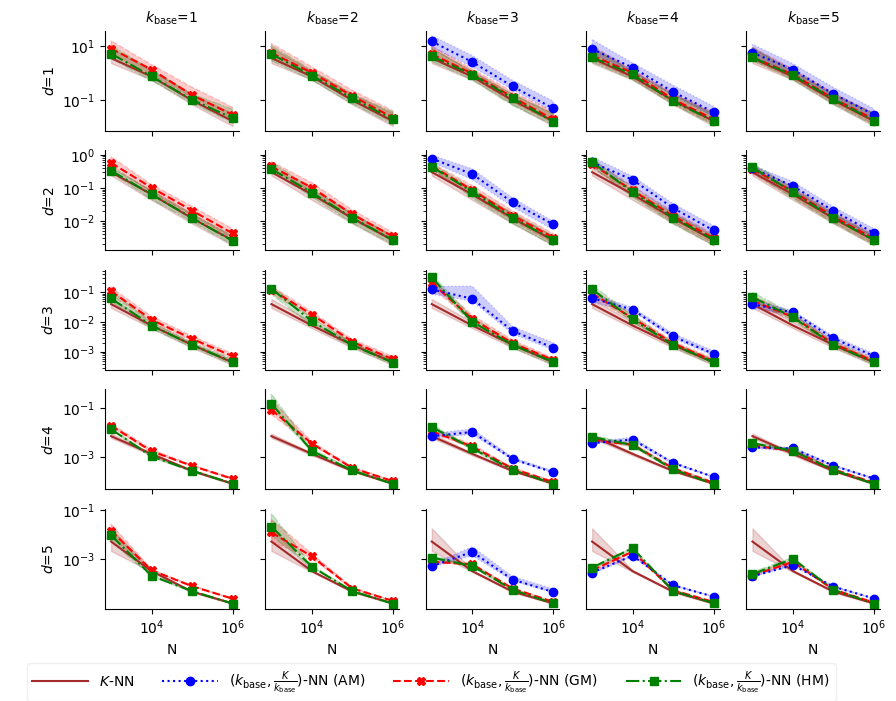

In [67]:
fig, axes = plt.subplots(
    nrows=len(ks), 
    ncols=len(dims), 
    figsize=(2. * len(ks), 1.5 * len(dims)),
    sharex='col',
    sharey='row',
    )
lines = []

for j, k in enumerate(ks):
    for i, d in enumerate(dims):
        for key in errs_l2[d]:
            ax = axes[i][j]
            
            # # if '3nn' in key or 'knn' in key or '1nn_hm' in key:
            # if 'nn_-2' in key:
            # if 'median' in key:
            #     plt.loglog(ns, errs_l2[key], marker='x', label=key)
            
            flag = 0
            if 'knn' in key:
                flag = 1
            if f'{k}nn' in key:
                flag = 1
            if 'median' in key:
                flag = 0
            if k in [1, 2]:
                if 'am' in key:
                    flag = 0
            if flag:
                plot_key = key
                for k_ in ks:
                    plot_key = plot_key.replace(f'{k_}nn', 'nn')
                # lines.append(
                ax.plot(
                    ns[1:], 
                    np.median(errs_l2[d][key], axis=-1)[1:], 
                    label=labels_dict[plot_key],
                    linestyle=linestyles[plot_key],
                    marker=markers[plot_key],
                    color=colors[plot_key],
                )
                ax.fill_between(
                    ns[1:],
                    np.quantile(errs_l2[d][key], 0.2, axis=-1)[1:],
                    np.quantile(errs_l2[d][key], 0.8, axis=-1)[1:],
                    linewidth=1, 
                    alpha=.2,
                    linestyle=linestyles[plot_key],
                    # marker=markers[plot_key],
                    color=colors[plot_key],
                    )

        if i == len(dims) - 1:
            ax.set_xlabel('N')
        ax.set_xscale('log', nonpositive='clip')
        ax.set_yscale('log', nonpositive='clip')
        ax.spines[[
            # 'left', 'bottom',
            'right', 'top'
        ]].set_visible(False)

        if i == 0:
            ax.set_title(r'$k_{\mathsf{base}}$'+f'={k}', fontsize=10)
        if j == 0:
            ax.set_ylabel(fr'$d$={d}')
        # ax.legend()
    
        # Reference: https://swdg.io/2015/errorbar-legends/
        handles, labels = ax.get_legend_handles_labels()
        handles = [h[0] if isinstance(h, mpl.container.ErrorbarContainer) else h for h in handles]

order = [0, 2, 1, 3]
legend = fig.legend(
    handles=[handles[i] for i in order],                # The line objects
    labels=[labels[i] for i in order],        # The labels for each line
    loc=(0.03, 0.0),#15),   # Position of legend
    # loc='lower center',
    ncol=4,
    borderaxespad=0.5,    # Small spacing around legend box
    handlelength=4,
)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(0.3)

# plt.subplots_adjust(wspace=.2, hspace=.2)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.2)
# fig.tight_layout()
plt.savefig('figs/exp_density.pdf', bbox_inches='tight')